In [2]:
## This notebook will be used to determine the extent that out threshold passed GI scores can recall PPI information
## from the STRING dataset

In [4]:
## Import modules

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
import requests

In [73]:
## Import data

## Import gene and sgrna interaction data
singles_table = pd.read_excel('/Users/benh/Desktop/GI_data/singles_tables/singles_table.xlsx',index_col = 0)

dmso2_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso2_map.xlsx',index_col = 0)
dmso2_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso2_sgmap.xlsx', index_col = 0)

etop_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/etop_map.xlsx',index_col = 0)
etop_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/etop_sgmap.xlsx', index_col = 0)

keto_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/keto_map.xlsx',index_col = 0)
keto_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/keto_sgmap.xlsx', index_col = 0)
keto_map = keto_map.fillna(0)

## Original experiment maps
dmso1_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso1_map.xlsx',index_col = 0)
dmso1_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso1_sgmap.xlsx',index_col = 0)

atr_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/atr_map.xlsx',index_col = 0)
atr_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/atr_sgmap.xlsx',index_col = 0)

In [254]:
## Define Functions here

##Import Max's handy upperTriangle function to avoid counting AB BA GIs twice
def upperTriangle(matrix, k=1):
    keep = np.triu(np.ones(matrix.shape), k=k).astype('bool').reshape(matrix.size)
    return matrix.stack(dropna=False).loc[keep]

def get_interactors(gimap,thresh):
    pos_list = []
    neg_list = []
    out_list = []
    for row in gimap.index:
        for col in gimap.columns:
            score = gimap.loc[row,col]
            if abs(score) > thresh:
                if col+':'+row not in out_list:
                    out_list.append(row+':'+col)
                    if score > 0:
                        pos_list.append(row+':'+col)
                    if score < 0:
                        neg_list.append(row+':'+col)
    return out_list, pos_list, neg_list

def int_range(gimap,low_thresh,high_thresh):
    out_list = []
    test = upperTriangle(gimap)
    for i, score in enumerate(test):
        if score > low_thresh:
            if score < high_thresh:
                out_list.append(test.index[i][0]+':'+test.index[i][1])
    return out_list

def pairs2score(in_list,in_map):
    out_list = []
    for item in in_list:
        g1,g2 = item.split(':')
        out_list.append(in_map.loc[g1,g2])
    return out_list

def plot_gi_rho(gimap, thresh, t_singles,ut_singles): 
    num_gis = []
    single_rho = []
    for gene in gimap.index:
        num_gis.append(len([val for val in gimap[gene] if abs(val) > thresh]))
        tau = t_singles.loc[gene_singlestable['gene']== gene]['b.mean'].mean()
        gamma = ut_singles.loc[gene_singlestable['gene']== gene]['b.mean'].mean()
        single_rho.append(tau-gamma)
    return plt.scatter(single_rho,num_gis,s=2,color = 'dimgray')

def all_unique_pair(gene_list):
    out_list = []
    for i in range(len(gene_list)):
        for j in range(i+1,len(gene_list)):
            out_list.append(gene_list[i]+':'+gene_list[j])
    return out_list
    
    
def ppi_scores(int_list):
    out_list=[]
    if len(int_list) == 0:
        return 0.0
    for pair in int_list:
        g1,g2 = pair.split(':')
        pair_rev = g2+':'+g1
        if pair in ppi_dict.keys():
            out_list.append(ppi_dict[pair])
        if pair_rev in ppi_dict.keys():
            out_list.append(ppi_dict[pair_rev])
        if pair not in ppi_dict.keys() and pair_rev not in ppi_dict.keys():
            out_list.append(0)
    return np.mean(out_list)

def binary_ppi_ratio(int_list):
    ppi_count = 0
    if len(int_list) == 0:
        return 0
    for pair in int_list:
        g1,g2 = pair.split(':')
        pair_rev = g2+':'+g1
        if pair in ppi_dict.keys():
            if ppi_dict[pair] > 0.0:
                ppi_count += 1
        if pair_rev in ppi_dict.keys():
            if ppi_dict[pair_rev] > 0.0:
                ppi_count += 1
    return ppi_count/len(int_list)
            
            
def ppi_pair(gene_pair):
    g1,g2 = gene_pair.split(':')
    pair_rev = g2+':'+g1
    if gene_pair in ppi_dict.keys():
        return ppi_dict[gene_pair]
    if pair_rev in ppi_dict.keys():
        return ppi_dict[pair_rev]
    if gene_pair not in ppi_dict.key() and pair_rev not in ppi_dict.keys():
        return 0

In [ ]:
## A color map from Max Horlbeck in his 14.33 notebook for drawing GI heatmaps in the traditional blue/yellow scheme

cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = matplotlib.colors.LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad('w')

plt.register_cmap(cmap=blue_yellow)

In [7]:
## Fill nan values in the map with zeros

dmso1_map = dmso1_map.fillna(0)
atr_map = atr_map.fillna(0)
dmso2_map = dmso2_map.fillna(0)
etop_map = etop_map.fillna(0)
keto_map = keto_map.fillna(0)

dmso1_sgmap = dmso1_sgmap.fillna(0)
atr_sgmap = atr_sgmap.fillna(0)
dmso2_sgmap = dmso2_sgmap.fillna(0)
etop_sgmap = etop_sgmap.fillna(0)
keto_sgmap = keto_sgmap.fillna(0)

In [8]:
## Make gene-sgneg map subsets

dmso2_geneneg = dmso2_sgmap.loc[singles_table['gene'] == 'non-targeting',
               :].groupby(singles_table['gene'],axis=1).mean()

etop_geneneg = etop_sgmap.loc[singles_table['gene'] == 'non-targeting',
               :].groupby(singles_table['gene'],axis=1).mean()

keto_geneneg = keto_sgmap.loc[singles_table['gene'] == 'non-targeting',
               :].groupby(singles_table['gene'],axis=1).mean()

dmso1_geneneg = dmso1_sgmap.loc[singles_table['gene'] == 'non-targeting',
               :].groupby(singles_table['gene'],axis=1).mean()

atr_geneneg = atr_sgmap.loc[singles_table['gene'] == 'non-targeting',
               :].groupby(singles_table['gene'],axis=1).mean()

In [10]:
## Repave all gene-ntc maps based off the index from one of the gene level maps

dmso1_geneneg = dmso1_geneneg.loc[:,dmso1_map.index]
atr_geneneg = atr_geneneg.loc[:,dmso1_map.index]
dmso2_geneneg = dmso2_geneneg.loc[:,dmso1_map.index]
etop_geneneg = etop_geneneg.loc[:,dmso1_map.index]
keto_geneneg = keto_geneneg.loc[:,dmso1_map.index]

In [11]:
## Define significance thresholds for each map at four times the standard deviation of the gene-ntc distribution

dmso1_thresh = np.hstack(dmso1_geneneg.values).std()*4
atr_thresh = np.hstack(atr_geneneg.values).std()*4
dmso2_thresh = np.hstack(dmso2_geneneg.values).std()*4
etop_thresh = np.hstack(etop_geneneg.values).std()*4
keto_thresh = np.hstack(keto_geneneg.values).std()*4

In [12]:
## Use the "get_interactors" functions to define lists of threshold passed interactors in each map

dmso1_all,dmso1_pos,dmso1_neg = get_interactors(dmso1_map,dmso1_thresh)
atr_all,atr_pos,atr_neg = get_interactors(atr_map,atr_thresh)
dmso2_all,dmso2_pos,dmso2_neg = get_interactors(dmso2_map,dmso2_thresh)
etop_all,etop_pos,etop_neg = get_interactors(etop_map,etop_thresh)
keto_all,keto_pos,keto_neg = get_interactors(keto_map,keto_thresh)

In [13]:
## Import STRING interactions
## Pipeline used from here https://towardsdatascience.com/visualizing-protein-networks-in-python-58a9b51be9d5

protein_list = list(dmso1_map.index)

proteins = '%0d'.join(protein_list)
url = 'https://string-db.org/api/tsv/network?identifiers=' + proteins + '&species=9606'
r = requests.get(url)
lines = r.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
df = pd.DataFrame(data[1:-1], columns = data[0]) 
interactions = df[['preferredName_A', 'preferredName_B', 'escore','ascore','dscore']]
interactions.columns = ['geneA','geneB','PPI','coEx','DB']
interactions = interactions.loc[interactions.index % 2 == 0]
interactions.index = range(0,len(interactions.index))

In [47]:
ppi_dict = dict()
for i in interactions.index:
    ppi_dict[interactions.loc[i,'geneA']+':'+interactions.loc[i,'geneB']] =float(interactions.loc[i,'PPI'])

In [56]:
dmso2_ppi_scores = ppi_scores(dmso2_all)
etop_ppi_scores = ppi_scores(etop_all)
keto_ppi_scores = ppi_scores(keto_all)
dmso1_ppi_scores = ppi_scores(dmso1_all)
atr_ppi_scores = ppi_scores(atr_all)

In [59]:
print(dmso2_ppi_scores,etop_ppi_scores,keto_ppi_scores,dmso1_ppi_scores,atr_ppi_scores)

0.04054145728643216 0.019976638546398445 0.04676740740740741 0.034856744186046514 0.021628522139160437


In [62]:
all_scores = ppi_scores(all_unique_pair(dmso1_map.index))

In [247]:
binary_ppi_ratio(all_unique_pair(dmso1_map.index))

0.03317700191071739

([0.02855570502629326,
  0.034668608885651854,
  0.04234527687296417,
  0.07,
  0.07575757575757576,
  0.19047619047619047,
  0.25],
 [16354, 6865, 1535, 300, 66, 21, 12])

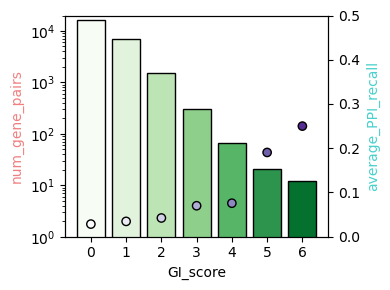

In [324]:
max_score = 7
jump = 1.0
num_pairs = []
scores = []
for i in np.arange(0,max_score,jump):
    pairs = int_range(dmso1_map,i,i+jump)
    num_pairs.append(len(pairs))
    scores.append(binary_ppi_ratio(pairs))
num_bins = len(np.arange(0,max_score,jump))

fig, ax1 = plt.subplots()
cmap = sns.color_palette("Greens", as_cmap=True)
ax1.set_xlabel('GI_score')
ax1.set_ylabel('num_gene_pairs',color = 'lightcoral')
ax1.bar(np.arange(0,max_score,jump),num_pairs,width = 0.8,color=cmap(np.arange(0,1,1/num_bins)),edgecolor = 'black')
ax1.tick_params(axis='y')
ax1.set_yscale('log')
ax1.set_ylim(1,20000)
ax2 = ax1.twinx() 

cmap = sns.color_palette("Purples", as_cmap=True)
ax2.set_ylabel('average_PPI_recall',color = 'mediumturquoise') 
ax2.scatter(np.arange(0,max_score,jump),scores, color=cmap(np.arange(0,1,1/num_bins)),edgecolor='black')
ax2.set_ylim(0,0.5)
ax2.set_xticks([0,1,2,3,4,5,6])

fig.set_size_inches(4, 3)
fig.tight_layout() 
plt.show()
fig.savefig('/Users/benh/Desktop/for_figs/dmso1_ppi_recall.png',dpi=300)

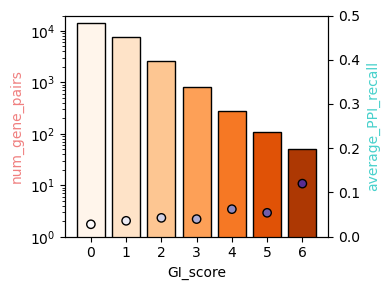

In [325]:
max_score = 7
jump = 1.0
num_pairs = []
scores = []
for i in np.arange(0,max_score,jump):
    pairs = int_range(atr_map,i,i+jump)
    num_pairs.append(len(pairs))
    scores.append(binary_ppi_ratio(pairs))
num_bins = len(np.arange(0,max_score,jump))

fig, ax1 = plt.subplots()
cmap = sns.color_palette("Oranges", as_cmap=True)
ax1.set_xlabel('GI_score')
ax1.set_ylabel('num_gene_pairs',color = 'lightcoral')
ax1.bar(np.arange(0,max_score,jump),num_pairs,width = 0.8,color=cmap(np.arange(0,1,1/num_bins)),edgecolor='black')
ax1.tick_params(axis='y')
ax1.set_yscale('log')
ax1.set_ylim(1,20000)
ax2 = ax1.twinx() 

cmap = sns.color_palette("Purples", as_cmap=True)
ax2.set_ylabel('average_PPI_recall',color = 'mediumturquoise') 
ax2.scatter(np.arange(0,max_score,jump),scores, color=cmap(np.arange(0,1,1/num_bins)),edgecolor='black')
ax2.set_ylim(0,0.5)
ax2.set_xticks([0,1,2,3,4,5,6])

fig.set_size_inches(4, 3)
fig.tight_layout() 
plt.show()
fig.savefig('/Users/benh/Desktop/for_figs/atr_ppi_recall.png',dpi=300)